In [1]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pymc3


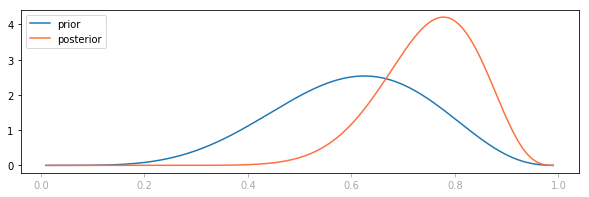

In [5]:
a,b= 6,4
N,h = 10,9
dist_in = np.arange(.01,.99,.0001)

plt.figure(figsize=(10,3))

beta_prior = stats.beta(a,b)
beta_posterior = stats.beta(a+h,b+N-h)
dist_prior = beta_prior.pdf(dist_in)
dist_posterior = beta_posterior.pdf(dist_in)

plt.plot(dist_in,dist_prior,color='#1f77b4', label='prior')
plt.plot(dist_in,dist_posterior,color='#FF703E', label='posterior')
plt.tick_params(axis='x', colors='darkgrey')
plt.legend(loc=2)

plot_images(plt, '3_1')

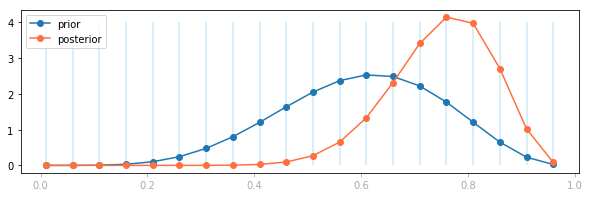

In [6]:
a,b= 6,4
N,h = 10,9
dist_in = np.arange(.01,.99,.05)

plt.figure(figsize=(10,3))

beta_prior = stats.beta(a,b)
binom_likelihood = stats.binom(N, dist_in)
dist_prior = beta_prior.pdf(dist_in)
likelihood = binom_likelihood.pmf(h)
dist_posterior = dist_prior*likelihood
dist_posterior /= (dist_posterior.sum() / len(dist_in))

plt.plot(dist_in, dist_prior,color='#1f77b4',marker='o', label='prior')
plt.plot(dist_in, dist_posterior,color='#FF703E',marker='o', label='posterior')
plt.vlines(dist_in,np.repeat(4,len(dist_in)),np.repeat(0,len(dist_in)), 
           linewidth=.3, color = '#008DE8')

plt.tick_params(axis='x', colors='darkgrey')
plt.legend(loc=2)

plot_images(plt, '3_2')

# large sample approximation:

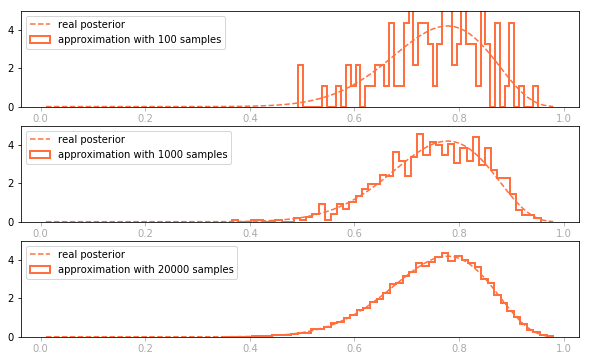

In [11]:
f, axes = plt.subplots(3,1,sharey='col', figsize=(10,6))
dist_in = np.arange(.01,.99,.01)
beta_posterior = stats.beta(a+h,b+N-h)
dist_posterior = beta_posterior.pdf(dist_in)

N_samples = [100,1000,20000]

for j,ax in enumerate(axes):
    ax.plot(dist_in,dist_posterior,'--',color='#FF703E', label='real posterior')
    ax.hist(beta_posterior.rvs(N_samples[j]), 50, histtype='step', normed=True, linewidth=2, label='approximation with '+str(N_samples[j])+' samples', color = '#FF703E');
    ax.set_ylim(0,5)
    ax.tick_params(axis='x', colors='darkgrey')
    ax.legend(loc=2)

plot_images(plt, '3_3')

In [12]:
def p_move(p_current, p_proposed):
    return min(p_proposed/p_current,1)

N_warmup = 5000


def metropolis_hastings(N_iterations):
    dist_in = np.arange(0,1,.01)
    beta_posterior = stats.beta(a+h,b+N-h)
    p_distribution_discrete = beta_posterior.pdf(dist_in)
    p_norm = p_distribution_discrete/p_distribution_discrete.sum()
    curr_pos = len(dist_in)//2
    path = np.zeros(N_iterations+1)

    for i in range(N_iterations):
        path[i]=dist_in[curr_pos]
        proposed_pos = curr_pos+np.random.choice([-1,1])
        if np.random.uniform()<p_move(p_norm[curr_pos], p_norm[proposed_pos]):
            curr_pos = proposed_pos
    return path    

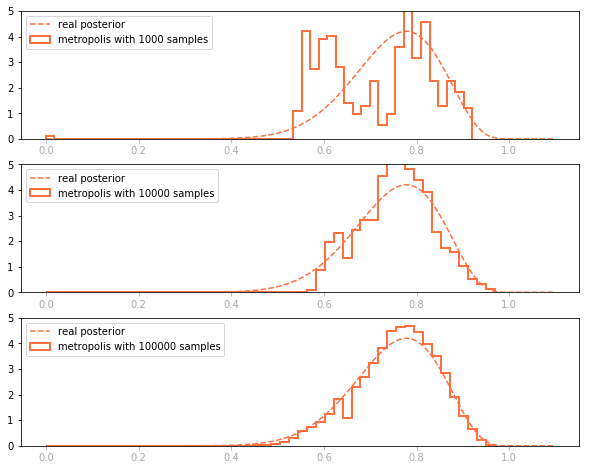

In [13]:
N_samples = [1000,10000,100000]

f, axes = plt.subplots(3,1,sharey='col', figsize=(10,8))
dist_in = np.arange(0,1.1,.005)
dist_posterior = beta_posterior.pdf(dist_in)

for j,ax in enumerate(axes):
    path = metropolis_hastings(N_samples[j])
    ax.plot(dist_in,dist_posterior,'--',color='#FF703E', label='real posterior')
    ax.hist(path[len(path)//2:], 50, histtype='step', normed=True, linewidth=2, label='metropolis with '+str(N_samples[j])+' samples', color = '#FF703E');
    ax.set_ylim(0,5)
    ax.tick_params(axis='x', colors='darkgrey')
    ax.legend(loc=2)

plot_images(plt, '3_extra1')

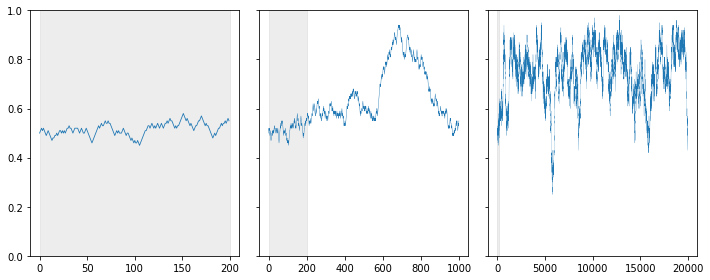

In [14]:
f, axes = plt.subplots(1,3, sharey=True, figsize=(10,4))

axes[0].plot(path[0:200], color='#1f77b4', linewidth=.80)
axes[1].plot(path[0:1000], color='#1f77b4', linewidth=.40)
axes[2].plot(path[0:20000], color='#1f77b4', linewidth=.20)
for ax in axes:
    ax.set_ylim(0,1)
    ax.fill_between([0,200],[1,1], alpha=.2, color='darkgrey')

plt.tight_layout()
plot_images(plt, '3_extra2')

# for the continuous case:

In [47]:
# setup

a,b = 6,4
N,h = 10,9
N_iterations = 10000
N_warmup = 5000
theta_path = np.zeros(N_iterations+1)
curr_theta = 0.5
iter_accepted = 0

# define distributions
beta_prior = stats.beta(a,b)
binom_likelihood = stats.binom
delta_norm = stats.norm(0,.2)

def p_accept(likelihood, prior, N, h, theta) :
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(N,theta).pmf(h)*prior.pdf(theta)

def p_move(p_current, p_proposed):
    return min(p_proposed/p_current,1)    
    
for i in range(N_iterations):
    theta_path[i] = curr_theta
    proposed_theta = curr_theta+delta_norm.rvs()
    if np.random.uniform()<p_move(p_accept(binom_likelihood, beta_prior, N, h, curr_theta),
                                  p_accept(binom_likelihood, beta_prior, N, h, proposed_theta)):
        iter_accepted += 1
        curr_theta = proposed_theta


        


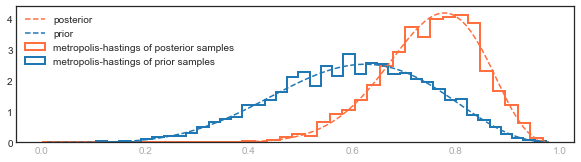

In [54]:
plt.figure(figsize=(10,2.5))
dist_in = np.arange(.01,.99,.01)

beta_posterior = stats.beta(a+h,b+N-h)
dist_posterior = beta_posterior.pdf(dist_in)
dist_prior_sampled = beta_prior.rvs(len(theta_path)-N_warmup)
dist_prior = beta_prior.pdf(dist_in)

plt.plot(dist_in,dist_posterior,'--',color='#FF703E', label='posterior')
plt.plot(dist_in,dist_prior, '--',color='#1f77b4', label='prior')

plt.hist(theta_path[N_warmup:], 40, histtype='step', normed=True, linewidth=2, label='metropolis-hastings of posterior samples', color = '#FF703E');
plt.hist(dist_prior_sampled, 40, histtype='step', normed=True, linewidth=2, label='metropolis-hastings of prior samples', color = '#1f77b4');

plt.tick_params(axis='x', colors='darkgrey')
plt.legend(loc=2)

plot_images(plt, '3_4')

In [49]:
print(np.round(iter_accepted/N_iterations*100,2),'% of proposals accepted')

48.33 % of proposals accepted


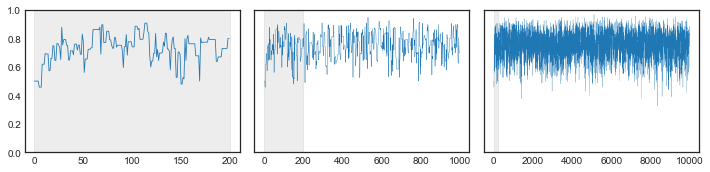

In [53]:
f, axes = plt.subplots(1,3, sharey=True, figsize=(10,2.5))

axes[0].plot(theta_path[0:200], color='#1f77b4', linewidth=.80)
axes[1].plot(theta_path[0:1000], color='#1f77b4', linewidth=.40)
axes[2].plot(theta_path[0:10000], color='#1f77b4', linewidth=.20)
for ax in axes:
    ax.set_ylim(0,1)
    ax.fill_between([0,200],[1,1], alpha=.2, color='darkgrey')

plt.tight_layout()
plot_images(plt, '3_5')

# multidimensional parameter sampling

In [19]:
import seaborn as sns
sns.set_style('white')
from mpl_toolkits.mplot3d import proj3d

def bern2d(theta1, theta2,z1,z2,N1,N2):
    return stats.binom(N1,theta1).pmf(h1)*stats.binom(N2,theta2).pmf(h2)

def orthogonal_proj(zfront, zback):
    a = (zfront+zback)/(zfront-zback)
    b = -2*(zfront*zback)/(zfront-zback)
    return np.array([[1,0,0,0],
                        [0,1,0,0],
                        [0,0,a,b],
                        [0,0,-0.0001,zback]])
proj3d.persp_transformation = orthogonal_proj

In [28]:
def plot_isocline(X,y,colormap,prior,likelihood,posterior):

    fig, axes = plt.subplots(1,3, sharey=True, figsize=(11,7), subplot_kw=dict(projection=None))
    for ax in np.ravel(axes):
        ax.set(adjustable='box-forced', aspect='equal')

    axes[0].contour(X, Y, prior, cmap=colormap)
    axes[1].contour(X, Y, likelihood, cmap=colormap)
    axes[2].contour(X, Y, posterior, cmap=colormap)

    for j,title in enumerate(['prior','likelihood','posterior']):
        axes[j].set_title(title, size=14)
    
    return fig

def plot_3D_surf(X,y,colormap,prior,likelihood,posterior):

    fig, axes_3d = plt.subplots(1,3, figsize=(9.2,4), subplot_kw=dict(projection='3d'))

    axes_3d[0].plot_surface(X, Y, prior, cmap=colormap, cstride=2)
    axes_3d[1].plot_surface(X, Y, likelihood, cmap=colormap, cstride=2)
    axes_3d[2].plot_surface(X, Y, posterior, cmap=colormap, cstride=2)

    for ax in axes_3d:
        ax.axis('off')
        ax.view_init(30, -125)
        ax.dist = 8

    plt.tight_layout()
    return fig    
    


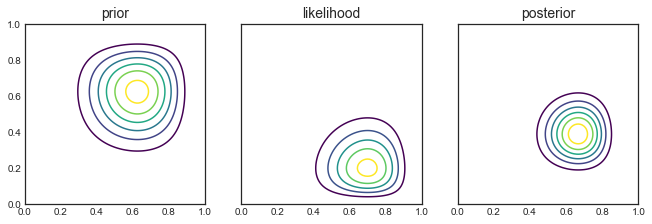

In [29]:
a,b = 6,4
thetas1 = np.linspace(0, 1, 101)
thetas2 = np.linspace(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)
h1 = 7
N1 = 10
h2 = 2
N2 = 10

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2d(X, Y, h1, h2, N1, N2)
posterior = stats.beta(a + h1, b + N1 - h1).pdf(X) * stats.beta(a + h2, b + N2 - h2).pdf(Y)

plot_images(plot_isocline(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_6')

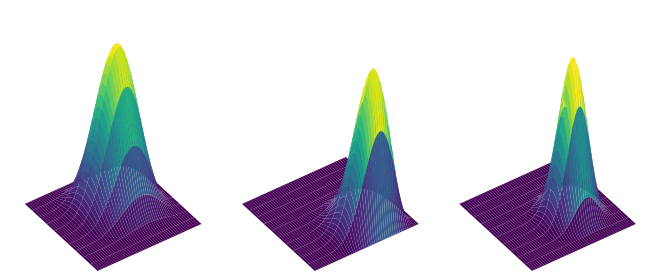

In [30]:
plot_images(plot_3D_surf(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_7')

# grid approximation

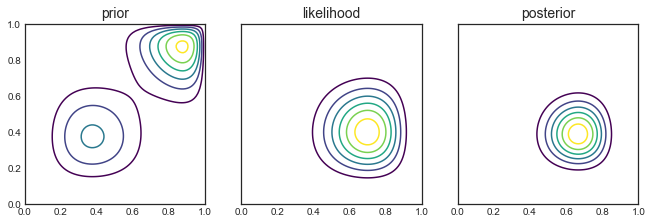

In [31]:
a,b = 4,6
a2,b2 = 8,2

thetas1 = np.linspace(0, 1, 101)
thetas2 = np.linspace(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)
h1 = 7
N1 = 10
h2 = 4
N2 = 10

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y) + stats.beta(a2, b2).pdf(X) * stats.beta(a2, b2).pdf(Y)
likelihood = bern2d(X, Y, h1, h2, N1, N2)
posterior_grid = likelihood * prior

plot_images(plot_isocline(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_extra3')

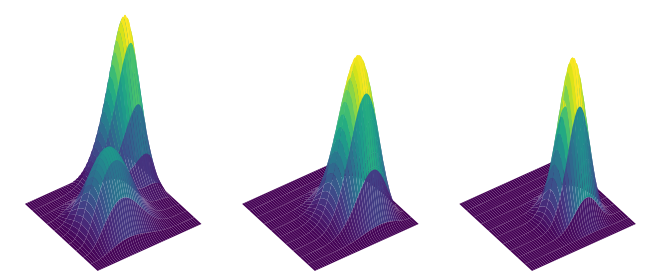

In [32]:
plot_images(plot_3D_surf(X,Y,plt.cm.viridis,prior,likelihood,posterior),'3_extra4')

# metropolis/hastings

In [33]:
def p_accept(likelihood, prior, N, h, theta) :
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(N,theta).pmf(h)*prior.pdf(theta)

def multivariate_prior(theta1, theta2):
    return stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)

def multivariate_likelihood(theta1, theta2):
    return bern2d(theta1, theta2, h1, h2, N1, N2)

def multivariate_accept(theta1, theta2):
    return multivariate_prior(theta1, theta2)*multivariate_likelihood(theta1, theta2)


In [35]:
a,b = 6,4
thetas1 = np.linspace(0, 1, 101)
thetas2 = np.linspace(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)
h1 = 7
N1 = 10
h2 = 2
N2 = 10

curr_theta = np.array([0.5, 0.5])
N_iterations = 10000
N_warmup = 4000
iter_accepted = 0

theta_path = np.zeros((N_iterations+1,2))

for i in range(N_iterations):
    theta_path[i] = curr_theta
    proposed_theta = curr_theta+stats.multivariate_normal([0,0], np.diag([0.2,0.2])).rvs()
    p = min(multivariate_accept(*proposed_theta)/multivariate_accept(*curr_theta), 1)
    if np.random.rand() < p:
        curr_theta = proposed_theta
        iter_accepted += 1

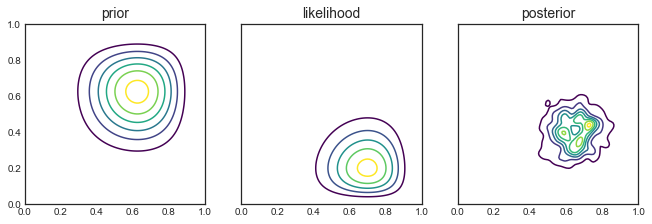

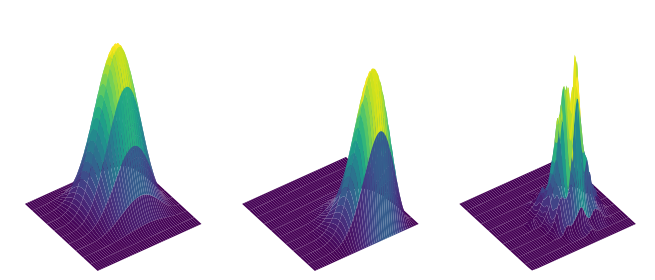

In [36]:
prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2d(X, Y, h1, h2, N1, N2)

kde = stats.gaussian_kde(theta_path[N_warmup:].T)
posterior = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plot_images(plot_isocline(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_extra5')
plot_images(plot_3D_surf(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_extra6')


In [37]:
print(np.round(iter_accepted/N_iterations*100,2),'% of proposals accepted')

9.36 % of proposals accepted


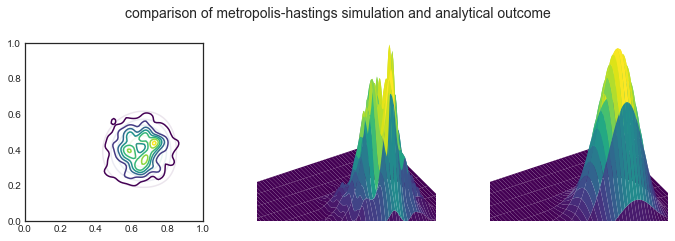

In [38]:
fig = plt.figure(figsize=(10,3))
ax_1 = fig.add_subplot(131, projection=None, adjustable='box-forced', aspect='equal')
ax_2 = fig.add_subplot(132, projection='3d', adjustable='box-forced', aspect='equal')
ax_3 = fig.add_subplot(133, projection='3d', adjustable='box-forced', aspect='equal')

ax_1.contour(X, Y, posterior, cmap=plt.cm.viridis)
ax_1.contour(X, Y, stats.beta(a + h1, b + N1 - h1).pdf(X) * stats.beta(a + h2, b + N2 - h2).pdf(Y), cmap=plt.cm.viridis, alpha=.1)

ax_2.plot_surface(X, Y, posterior, cmap=plt.cm.viridis, cstride=2)
ax_3.plot_surface(X, Y, stats.beta(a + h1, b + N1 - h1).pdf(X) * stats.beta(a + h2, b + N2 - h2).pdf(Y), cmap=plt.cm.viridis, cstride=2)

fig.suptitle('comparison of metropolis-hastings simulation and analytical outcome',size=14, y=1.1)

for ax in [ax_2,ax_3]:
    ax.axis('off')
    ax.view_init(35, -120)
    ax.dist = 4.8

plt.tight_layout()
plot_images(plt, '3_8')


# gibbs

In [39]:
a,b = 6,4
thetas1 = np.linspace(0, 1, 101)
thetas2 = np.linspace(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)
h1 = 7
N1 = 10
h2 = 2
N2 = 10

curr_theta = np.array([0.5, 0.5])
N_iterations = 10000
N_warmup = 4000

theta_path = np.zeros((N_iterations+1,2))

for i in range(N_iterations):
    theta_path[i] = curr_theta
    curr_theta = [stats.beta(a + h1, b + N1 - h1).rvs(), curr_theta[1]]
    curr_theta = [curr_theta[0], stats.beta(a + h2, b + N2 - h2).rvs()]

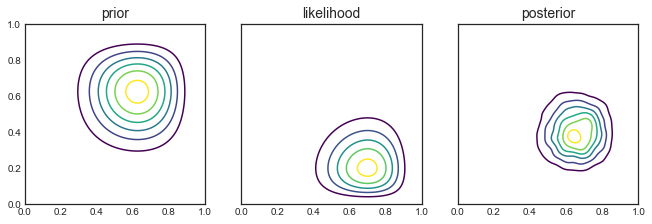

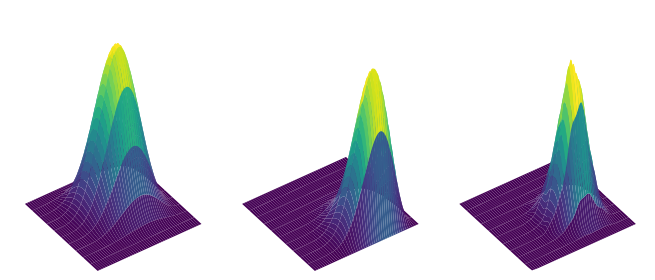

In [40]:
prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2d(X, Y, h1, h2, N1, N2)

kde = stats.gaussian_kde(theta_path[N_warmup:].T)
posterior = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plot_images(plot_isocline(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_extra7')
plot_images(plot_3D_surf(X,Y,plt.cm.viridis,prior,likelihood,posterior), '3_extra8')